<a href="https://colab.research.google.com/github/tkornuta-semiotic/2023-05-AI-workshop/blob/main/notebooks/Image_Recognition_with_HuggingFace_and_ResNet_FineTuning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Kaggle-based Tutorial: Image Recognition with HuggingFace and Colab

Description: In this tutorial, you will learn how to train an image recognition model using HuggingFace's datasets and models, and monitor training vs validation accuracy to detect overfitting. You will also learn how to fine-tune a pretrained ResNet encoder to achieve faster convergence.

In [7]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models, transforms

from datasets import load_dataset
from transformers import AutoTokenizer

from torch.utils.tensorboard import SummaryWriter

# CIFAR-10/CIFAR-100 datasets

CIFAR-10 and CIFAR-100 are two classical image classification datasets that are often used as benchmarks for testing and evaluating computer vision models.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**. There are 50,000 training images and 10,000 test images.

The CIFAR-100 dataset is similar to CIFAR-10, but with 100 classes, each containing 600 images. The 100 classes are grouped into 20 superclasses, each containing 5 subclasses. The subclasses are highly diverse and include items such as insects, flowers, trees, household appliances, and vehicles.

Both CIFAR-10 and CIFAR-100 are widely used in the research community as standard benchmarks for image classification tasks, due to their relatively small size, ease of use, and availability.



In [14]:
### Step 2: Load the dataset
# 2.1 Choose an image dataset from HuggingFace's datasets library.
dataset = load_dataset('cifar10')

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
# Step 3: Preprocessing
# 3.1 Change samples int the test set to tensors.

transform = transforms.ToTensor()

test_set = dataset['test'].map(lambda x: {'img': transform(x['img'])})

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

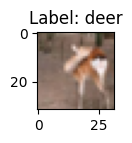

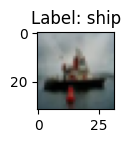

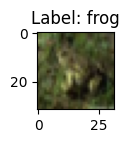

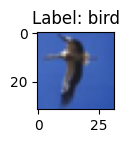

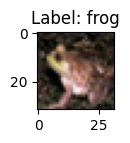

In [29]:
# Show some samples using MatPlotLib.
import matplotlib.pyplot as plt
import numpy as np

cifar10_class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def imshow(img, title=None):
    plt.figure(figsize=(1, 1))  # Set the figure size to 2 inches by 2 inches
    plt.imshow(np.transpose(img, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def show_samples(dataset, num_samples=5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i in indices:
        sample = dataset[int(i)]
        image = sample['img']
        label = sample['label']
        text_label = cifar10_class_names[label]  # Convert numeric label to text label
        imshow(image, f"Label: {text_label}")

show_samples(test_set, num_samples=5)

This tutorial will highlight impact of leveraging pretrained image encoders, i.e. features learned by the model on another (bigger) dataset.

In particular, in the second part we will fine-tune ResNet-18 model pretrained on the ImageNet dataset. ImageNet is a large-scale dataset containing more than 14 million images across 20,000 categories. The pretrained models provided by torchvision have been trained on a subset of ImageNet with 1,000 categories and 1.2 million images.

When using a pretrained model, it's important to apply the same preprocessing and normalization that was used during the original pretraining. For the ImageNet dataset, the following normalization is typically used:

In [34]:
# 3.2 Change samples in the training and validation sets to tensors, and
# additionally apply a typical ImageNet normalization.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = dataset['train'].map(lambda x: {'img': transform(x['img'])})
valid_set = dataset['test'].map(lambda x: {'img': transform(x['img'])})

dict_keys(['train', 'test'])